In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import csv

import os
import pickle

from catch_converter.parse_contours import parse_cvi42ws
from LazyLuna.Mini_LL import *
from LazyLuna.CATCH_utils import *
from LazyLuna.Figures import *

In [2]:
def T1_diff_bullseye_plot(means, stds, fig, ax, segBold=[], minv=None, maxv=None):
    # requires polar projection: fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(21,12), subplot_kw=dict(projection='polar'))
    cmap = plt.cm.viridis
    #cmap = plt.cm.gnuplot # ??? which colormap?
    #cmap = plt.cm.bwr
    cmap = plt.cm.PRGn
    if minv is None: minv=np.min(means)-5
    if maxv is None: maxv=np.max(means)+5
    minv, maxv = min([minv, -maxv]), max([maxv, -minv])
    norm = mpl.colors.Normalize(vmin=minv, vmax=maxv)
    
    means = np.array(means).ravel()
    stds  = np.array(stds) .ravel()
    theta = np.linspace(0, 2*np.pi, 768)
    r = np.linspace(0.2, 1, 4)
    linewidth = 2
    
    for i in range(r.shape[0]): ax.plot(theta, np.repeat(r[i], theta.shape), '-k', lw=linewidth)
    for i in range(6):
        theta_i = i * 60 * np.pi/180
        ax.plot([theta_i, theta_i], [r[1], 1], '-k', lw=linewidth)
    for i in range(4):
        theta_i = i * 90 * np.pi/180 - 45*np.pi/180
        ax.plot([theta_i, theta_i], [r[0], r[1]], '-k', lw=linewidth)

    r0 = r[2:4]
    r0 = np.repeat(r0[:,np.newaxis], 128, axis=1).T
    for i in range(6):
        theta0 = theta[i*128:i*128+128] + 60*np.pi/180 #+ 60*np.pi/180
        theta0 = np.repeat(theta0[:,np.newaxis], 2, axis=1)
        write_val(ax, means[i], stds[i], i*60*np.pi/180 + 30*np.pi/180 + 60*np.pi/180, np.mean(r0[0]))
        z = np.ones((128,2)) * means[i]
        ax.pcolormesh(theta0, r0, z, cmap=cmap, norm=norm)
        if i+1 in segBold:
            ax.plot(theta0, r0, '-k', lw=linewidth+2)
            ax.plot(theta0[0 ], [r[2],r[3]], '-k', lw=linewidth+1)
            ax.plot(theta0[-1], [r[2],r[3]], '-k', lw=linewidth+1)

    r0 = r[1:3]
    r0 = np.repeat(r0[:,np.newaxis], 128, axis=1).T
    for i in range(6):
        theta0 = theta[i*128:i*128+128] + 60*np.pi/180 #+ 60*np.pi/180
        theta0 = np.repeat(theta0[:,np.newaxis], 2, axis=1)
        write_val(ax, means[i+6], stds[i+6],  i*60*np.pi/180 + 30*np.pi/180 + 60*np.pi/180, np.mean(r0[0]))
        z = np.ones((128,2)) * means[i+6]
        ax.pcolormesh(theta0, r0, z, cmap=cmap, norm=norm)
        if i+7 in segBold:
            ax.plot(theta0, r0, '-k', lw=linewidth+2)
            ax.plot(theta0[0 ], [r[1],r[2]], '-k', lw=linewidth+1)
            ax.plot(theta0[-1], [r[1],r[2]], '-k', lw=linewidth+1)

    r0 = r[0:2]
    r0 = np.repeat(r0[:,np.newaxis], 192, axis=1).T
    for i in range(4):
        theta0 = theta[i*192:i*192+192] + 45*np.pi/180  #+ 90*np.pi/180 
        theta0 = np.repeat(theta0[:,np.newaxis], 2, axis=1)
        write_val(ax,means[i+12], stds[i+12], i*90*np.pi/180 + 90*np.pi/180 , np.mean(r0[0]))
        z = np.ones((192,2)) * means[i+12]
        ax.pcolormesh(theta0, r0, z, cmap=cmap, norm=norm)
        if i+13 in segBold:
            ax.plot(theta0, r0, '-k', lw=linewidth+2)
            ax.plot(theta0[0 ], [r[0],r[1]], '-k', lw=linewidth+1)
            ax.plot(theta0[-1], [r[0],r[1]], '-k', lw=linewidth+1)

    ax.set_ylim([0, 1])
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    #Add legend
    #axl  = fig.add_axes([0.3, 0.04, 0.45, 0.05])
    #fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), 
    #             cax=axl, orientation='horizontal', label='T1 Colormap [ms]')
    axp    = ax.imshow(np.random.randint(0, 100, (100, 100)))
    cbaxes = fig.add_axes([0.78, 0.1, 0.03, 0.8])  # This is the position for the colorbar
    cb     = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax=axp, cax=cbaxes)
    return fig, ax
    
    
def write_val(ax, mean, std, angle, y):
    mean = "{:.1f}".format(float(mean))
    std  = "{:.1f}".format(float(std))
    ax.annotate(str(mean) + '\n(' + str(std) + ')',
            xy                  = (angle, y), # theta, radius
            xytext              = (angle, y), # fraction, fraction
            textcoords          = 'data',     #'figure fraction',
            bbox                = dict(boxstyle="round", fc="1.0", edgecolor="1.0"),
            horizontalalignment = 'center',
            size                = 10,
            verticalalignment   = 'center',
            )

In [ ]:
def T1_bullseye_plot(means, stds, fig, ax, segBold=[], minv=None, maxv=None, pos=1):
    # requires polar projection: fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(21,12), subplot_kw=dict(projection='polar'))
    #cmap = plt.cm.viridis
    cmap = plt.cm.gnuplot # ??? which colormap?
    cmap = plt.cm.bwr
    if minv is None: minv=np.min(means)
    if maxv is None: maxv=np.max(means)
    minv, maxv = min([minv, 995]), max([maxv, 1005])
    norm = mpl.colors.Normalize(vmin=minv, vmax=maxv)
    
    means = np.array(means).ravel()
    stds  = np.array(stds) .ravel()

    theta = np.linspace(0, 2*np.pi, 768)
    r = np.linspace(0.2, 1, 4)
    linewidth = 2
    
    for i in range(r.shape[0]): ax.plot(theta, np.repeat(r[i], theta.shape), '-k', lw=linewidth)
    for i in range(6):
        theta_i = i * 60 * np.pi/180
        ax.plot([theta_i, theta_i], [r[1], 1], '-k', lw=linewidth)
    for i in range(4):
        theta_i = i * 90 * np.pi/180 - 45*np.pi/180
        ax.plot([theta_i, theta_i], [r[0], r[1]], '-k', lw=linewidth)

    r0 = r[2:4]
    r0 = np.repeat(r0[:,np.newaxis], 128, axis=1).T
    for i in range(6):
        theta0 = theta[i*128:i*128+128] + 60*np.pi/180 #+ 60*np.pi/180
        theta0 = np.repeat(theta0[:,np.newaxis], 2, axis=1)
        write_val(ax, means[i], stds[i], i*60*np.pi/180 + 30*np.pi/180 + 60*np.pi/180, np.mean(r0[0]))
        z = np.ones((128,2)) * means[i]
        ax.pcolormesh(theta0, r0, z, cmap=cmap, norm=norm)
        if i+1 in segBold:
            ax.plot(theta0, r0, '-k', lw=linewidth+2)
            ax.plot(theta0[0 ], [r[2],r[3]], '-k', lw=linewidth+1)
            ax.plot(theta0[-1], [r[2],r[3]], '-k', lw=linewidth+1)

    r0 = r[1:3]
    r0 = np.repeat(r0[:,np.newaxis], 128, axis=1).T
    for i in range(6):
        theta0 = theta[i*128:i*128+128] + 60*np.pi/180 #+ 60*np.pi/180
        theta0 = np.repeat(theta0[:,np.newaxis], 2, axis=1)
        write_val(ax, means[i+6], stds[i+6],  i*60*np.pi/180 + 30*np.pi/180 + 60*np.pi/180, np.mean(r0[0]))
        z = np.ones((128,2)) * means[i+6]
        ax.pcolormesh(theta0, r0, z, cmap=cmap, norm=norm)
        if i+7 in segBold:
            ax.plot(theta0, r0, '-k', lw=linewidth+2)
            ax.plot(theta0[0 ], [r[1],r[2]], '-k', lw=linewidth+1)
            ax.plot(theta0[-1], [r[1],r[2]], '-k', lw=linewidth+1)

    r0 = r[0:2]
    r0 = np.repeat(r0[:,np.newaxis], 192, axis=1).T
    for i in range(4):
        theta0 = theta[i*192:i*192+192] + 45*np.pi/180  #+ 90*np.pi/180 
        theta0 = np.repeat(theta0[:,np.newaxis], 2, axis=1)
        write_val(ax,means[i+12], stds[i+12], i*90*np.pi/180 + 90*np.pi/180 , np.mean(r0[0]))
        z = np.ones((192,2)) * means[i+12]
        ax.pcolormesh(theta0, r0, z, cmap=cmap, norm=norm)
        if i+13 in segBold:
            ax.plot(theta0, r0, '-k', lw=linewidth+2)
            ax.plot(theta0[0 ], [r[0],r[1]], '-k', lw=linewidth+1)
            ax.plot(theta0[-1], [r[0],r[1]], '-k', lw=linewidth+1)

    ax.set_ylim([0, 1])
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    #Add legend
    #axl  = fig.add_axes([0.3, 0.04, 0.45, 0.05])
    #fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), 
    #             cax=axl, orientation='horizontal', label='T1 Colormap [ms]')
    axp    = ax.imshow(np.random.randint(0, 100, (100, 100)))
    cbaxes = fig.add_axes([0.78, 0.1, 0.03, 0.8])  # This is the position for the colorbar
    cb     = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax=axp, cax=cbaxes)
    
    return fig, ax
    
    
def write_val(ax, mean, std, angle, y):
    mean = "{:.1f}".format(float(mean))
    std  = "{:.1f}".format(float(std))
    ax.annotate(str(mean) + '\n(' + str(std) + ')',
            xy                  = (angle, y), # theta, radius
            xytext              = (angle, y), # fraction, fraction
            textcoords          = 'data',     #'figure fraction',
            bbox                = dict(boxstyle="round", fc="1.0", edgecolor="1.0"),
            horizontalalignment = 'center',
            size                = 10,
            verticalalignment   = 'center',
            )

<ipython-input-2-440770aa0ca8>:33: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(theta0, r0, z, cmap=cmap, norm=norm)
<ipython-input-2-440770aa0ca8>:46: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(theta0, r0, z, cmap=cmap, norm=norm)
<ipython-input-2-440770aa0ca8>:59: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals 

(<Figure size 864x576 with 2 Axes>, <PolarAxesSubplot:>)

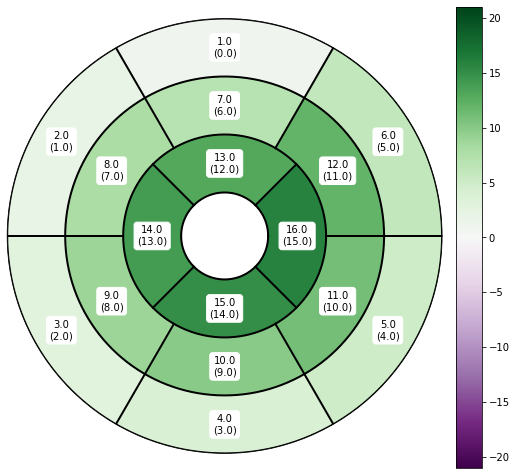

In [3]:
path = 'BullseyeTest.csv'
means, stds = [], []
with open(path, encoding="utf8") as csvdatei:
    csv_reader_object = csv.reader(csvdatei, delimiter='\t')
    for i, row in enumerate(csv_reader_object):
        if i==0: continue
        row = row[0].strip().split(';')
        mean, std = float(row[1].strip().replace(',','.')), float(row[2].strip().replace(',','.'))
        means.append(mean); stds.append(std)
    
#print(means)
#print(np.min(means), np.max(means))
means = np.arange(16) + 1
stds  = np.arange(16)

fig, ax = plt.subplots(1,1,figsize=(12,8), subplot_kw=dict(projection='polar'))
T1_diff_bullseye_plot(means, stds, fig=fig, ax=ax, segBold=[])

In [ ]:
bp_cases = '/Users/dietrichhadler/Desktop/Daten/CAMAID/Cases'
cases  = [pickle.load(open(os.path.join(bp_cases, p), 'rb')) for p in os.listdir(bp_cases)]
cases1 = sorted([c for c in cases if c.reader_name=='Gold'],     key=lambda c: c.case_name)
cases2 = sorted([c for c in cases if c.reader_name=='Reader2'],  key=lambda c: c.case_name)
v = SAX_T1_View()
ccs = []
for i in range(len(cases1)):
    try: ccs.append(Case_Comparison(v.customize_case(cases1[i]), v.customize_case(cases2[i])))
    except: pass

In [ ]:
c1   = ccs[0].case1
img  = c1.categories[0].get_img (1,0, True, False)
h, w = img.shape
anno = c1.categories[0].get_anno(1,0)
plt.imshow(img, cmap='gray'); 
mp = anno.get_contour('lv_endo').centroid
rp = anno.get_point('sacardialRefPoint')
plt.plot(mp.x, mp.y,'x',c='w')
plt.plot(rp.x, rp.y,'x',c='w')
plt.show()

#mask = anno.get_angle_mask_to_middle_point(h, w)
#plt.imshow(mask); plt.show()
mask = anno.get_angle_mask_to_middle_point_by_reference_point(h, w)
#plt.imshow(mask); plt.show()

plt.imshow(img + mask*10, cmap='gray')
plt.plot(mp.x, mp.y,'x',c='w')
plt.plot(rp.x, rp.y,'x',c='w')
plt.show()

myo_mask = anno.get_cont_as_mask('lv_myo', h, w)
fig, ax  = plt.subplots(1,1, figsize=(9,9))
ax.imshow(img + myo_mask*2000, cmap='gray')
anno.plot_contour_outlines(ax, 'lv_myo', edge_c=(1,0,0,1.0))
plt.show()

In [ ]:
def aha_model_plot(cc):
    c1, c2 = cc.case1, cc.case2
    aha_means1, aha_means2, aha_mean_diffs = [], [], []
    aha_stds1,  aha_stds2,  aha_std_diffs  = [], [], []
    for d in range(3):
        img  = c1.categories[0].get_img (d,0, True, False)
        h, w = img.shape
        anno = c1.categories[0].get_anno(d,0)
        values1 = anno.get_myo_mask_by_angles(img, 6 if d!=2 else 4)
        img  = c2.categories[0].get_img (d,0, True, False)
        anno = c2.categories[0].get_anno(d,0)
        values2 = anno.get_myo_mask_by_angles(img, 6 if d!=2 else 4)
        keys = list(values1.keys())[1:] + list(values1.keys())[:1]
        for k in keys:
            aha_means1.append(np.mean(values1[k]))
            aha_means2.append(np.mean(values2[k]))
            aha_mean_diffs.append(np.mean(values1[k])-np.mean(values2[k]))
            aha_stds1.append(np.std(values1[k]))
            aha_stds2.append(np.std(values2[k]))
            aha_std_diffs.append(np.std(values1[k])-np.std(values2[k]))
    fig1, ax1 = plt.subplots(1,1,figsize=(12,8), subplot_kw=dict(projection='polar'))
    fig2, ax2 = plt.subplots(1,1,figsize=(12,8), subplot_kw=dict(projection='polar'))
    fig3, ax3 = plt.subplots(1,1,figsize=(12,8), subplot_kw=dict(projection='polar'))
    T1_bullseye_plot     (aha_means1,     aha_stds1,     fig=fig1, ax=ax1, segBold=[], pos=1)
    T1_bullseye_plot     (aha_means2,     aha_stds2,     fig=fig2, ax=ax2, segBold=[], pos=2)
    T1_diff_bullseye_plot(aha_mean_diffs, aha_std_diffs, fig=fig3, ax=ax3, segBold=[])
    plt.show()
aha_model_plot(ccs[1])